## slope 实现1

In [1]:
#https://github.com/ofirpress/attention_with_linear_biases/blob/master/fairseq/models/transformer.py#L742

import math
def get_slopes(n):
    def get_slopes_power_of_2(n):
        start = (2**(-2**-(math.log2(n)-3)))
        ratio = start
        return [start*ratio**i for i in range(n)]

    if math.log2(n).is_integer():
        return get_slopes_power_of_2(n)                   #In the paper, we only train models that have 2^a heads for some a. This function has
    else:                                                 #some good properties that only occur when the input is a power of 2. To maintain that even
        closest_power_of_2 = 2**math.floor(math.log2(n))  #when the number of heads is not a power of 2, we use this workaround. 
        return get_slopes_power_of_2(closest_power_of_2) + get_slopes(2*closest_power_of_2)[0::2][:n-closest_power_of_2]

print(get_slopes(40))


[0.8408964152537145, 0.7071067811865475, 0.5946035575013604, 0.4999999999999999, 0.42044820762685714, 0.3535533905932737, 0.2973017787506802, 0.2499999999999999, 0.21022410381342854, 0.17677669529663678, 0.14865088937534005, 0.12499999999999992, 0.10511205190671426, 0.08838834764831839, 0.07432544468767001, 0.06249999999999995, 0.052556025953357115, 0.04419417382415918, 0.037162722343835, 0.03124999999999997, 0.02627801297667855, 0.022097086912079587, 0.018581361171917495, 0.015624999999999981, 0.013139006488339273, 0.01104854345603979, 0.009290680585958746, 0.007812499999999989, 0.006569503244169636, 0.005524271728019895, 0.004645340292979372, 0.003906249999999994, 0.9170040432046712, 0.7711054127039704, 0.6484197773255047, 0.5452538663326288, 0.45850202160233555, 0.38555270635198513, 0.32420988866275235, 0.27262693316631437]


In [2]:
# https://huggingface.co/baichuan-inc/Baichuan-13B-Base/blob/main/modeling_baichuan.py#L20

def _get_interleave(n):
    def _get_interleave_power_of_2(n):
        start = (2 ** (-2 ** -(math.log2(n) - 3)))
        ratio = start
        return [start * ratio ** i for i in range(n)]

    if math.log2(n).is_integer():
        return _get_interleave_power_of_2(n)
    else:
        closest_power_of_2 = 2 ** math.floor(math.log2(n))
        return _get_interleave_power_of_2(closest_power_of_2) + \
               _get_interleave(2 * closest_power_of_2)[0::2][:n - closest_power_of_2]
    
print(_get_interleave(40))

[0.8408964152537145, 0.7071067811865475, 0.5946035575013604, 0.4999999999999999, 0.42044820762685714, 0.3535533905932737, 0.2973017787506802, 0.2499999999999999, 0.21022410381342854, 0.17677669529663678, 0.14865088937534005, 0.12499999999999992, 0.10511205190671426, 0.08838834764831839, 0.07432544468767001, 0.06249999999999995, 0.052556025953357115, 0.04419417382415918, 0.037162722343835, 0.03124999999999997, 0.02627801297667855, 0.022097086912079587, 0.018581361171917495, 0.015624999999999981, 0.013139006488339273, 0.01104854345603979, 0.009290680585958746, 0.007812499999999989, 0.006569503244169636, 0.005524271728019895, 0.004645340292979372, 0.003906249999999994, 0.9170040432046712, 0.7711054127039704, 0.6484197773255047, 0.5452538663326288, 0.45850202160233555, 0.38555270635198513, 0.32420988866275235, 0.27262693316631437]


In [3]:
# https://nn.labml.ai/transformers/alibi/index.html
import torch

def get_slopes2(n_heads: int):
    n = 2 ** math.floor(math.log2(n_heads))
    m_0 = 2.0 ** (-8.0 / n)
    m = torch.pow(m_0, torch.arange(1, 1 + n))
    if n < n_heads:
        m_hat_0 = 2.0 ** (-4.0 / n)
        m_hat = torch.pow(m_hat_0, torch.arange(1, 1 + 2 * (n_heads - n), 2))
        m = torch.cat([m, m_hat])
    return m

print(get_slopes2(40).tolist())

[0.8408964276313782, 0.7071068286895752, 0.5946035981178284, 0.5, 0.4204482436180115, 0.3535534143447876, 0.2973017990589142, 0.2500000298023224, 0.21022413671016693, 0.176776722073555, 0.1486509144306183, 0.1250000149011612, 0.10511206835508347, 0.0883883684873581, 0.07432545721530914, 0.0625000149011612, 0.05255603790283203, 0.04419418424367905, 0.03716273233294487, 0.0312500074505806, 0.026278020814061165, 0.022097093984484673, 0.018581368029117584, 0.015625005587935448, 0.013139011338353157, 0.011048547923564911, 0.009290684014558792, 0.007812502793967724, 0.006569506134837866, 0.0055242739617824554, 0.004645342472940683, 0.003906251862645149, 0.9170040488243103, 0.7711054086685181, 0.6484197974205017, 0.5452538728713989, 0.45850205421447754, 0.3855527341365814, 0.32420992851257324, 0.27262696623802185]


In [4]:
# note that if n is NOT power of 2, the concat workaround will create 
# an abrupt change in values near 0.003906 => 0.917004

def assert_arr(arr1, arr2, tolerance = 1e-7):
    for i,j in zip(arr1,arr2):
        assert abs(i-j) <= tolerance
        
assert_arr(get_slopes(40),_get_interleave(40))
assert_arr(get_slopes(40),get_slopes2(40))

## slope 实现2

In [5]:
# https://github.com/jaketae/alibi/blob/main/alibi/attention.py#L16
    
import torch

def get_relative_positions(seq_len: int) -> torch.tensor:
    x = torch.arange(seq_len)[None, :]
    y = torch.arange(seq_len)[:, None]
    return x - y


def get_alibi_slope(num_heads):
    x = (2 ** 8) ** (1 / num_heads)
    return (
        torch.tensor([1 / x ** (i + 1) for i in range(num_heads)])
    )

print(get_alibi_slope(40).tolist())

[0.8705505728721619, 0.7578582763671875, 0.6597539782524109, 0.5743491649627686, 0.5, 0.43527528643608093, 0.37892913818359375, 0.32987698912620544, 0.2871745824813843, 0.25, 0.21763764321804047, 0.18946456909179688, 0.16493849456310272, 0.14358729124069214, 0.125, 0.10881882160902023, 0.09473228454589844, 0.08246924728155136, 0.07179364562034607, 0.0625, 0.05440941080451012, 0.04736614227294922, 0.04123462364077568, 0.035896822810173035, 0.03125, 0.02720470540225506, 0.02368307113647461, 0.02061731182038784, 0.017948411405086517, 0.015625, 0.01360235270112753, 0.011841535568237305, 0.01030865591019392, 0.008974205702543259, 0.0078125, 0.006801176350563765, 0.005920767784118652, 0.00515432795509696, 0.004487102851271629, 0.00390625]


## compare slope

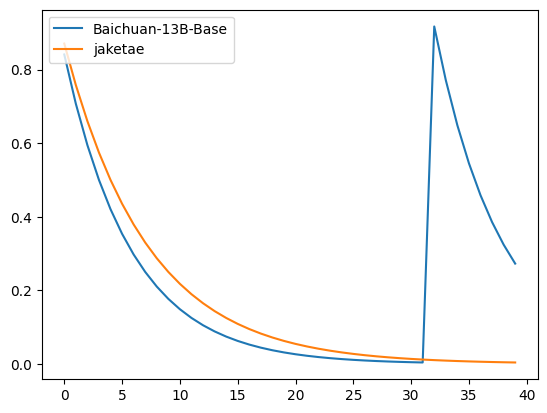

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
#     'ofirpress': get_slopes(40),
    'Baichuan-13B-Base': _get_interleave(40),
#     'labml': get_slopes2(40),
    'jaketae': get_alibi_slope(40).tolist()
},index=([i for i in range(40)]))

df.plot(kind='line')
plt.legend(loc='upper left')
plt.show()

## alibi mask 实现 （基于slope 实现 2）

$$
softmax(q_{i}\textbf{K}^{\top} + m \cdot [−(i − 1), ..., −2, −1, 0])
$$


In [7]:
import torch

def get_relative_positions(seq_len: int) -> torch.tensor:
    x = torch.arange(seq_len)[None, :]
    y = torch.arange(seq_len)[:, None]
    return x - y


def get_alibi_slope(num_heads):
    x = (2 ** 8) ** (1 / num_heads)
    return (
        torch.tensor([1 / x ** (i + 1) for i in range(num_heads)])
    )

num_heads = 10

m = get_alibi_slope(num_heads).unsqueeze(-1).unsqueeze(-1)
print(m.shape)
print(m)

seq_len = 6
bias = m * get_relative_positions(seq_len).unsqueeze(0)

# fill upper right with -inf
t = torch.full((seq_len, seq_len), float("-inf"))
t = torch.triu(t, diagonal=1)
bias  = bias + t
print(bias.shape)
print(bias)

torch.Size([10, 1, 1])
tensor([[[0.5743]],

        [[0.3299]],

        [[0.1895]],

        [[0.1088]],

        [[0.0625]],

        [[0.0359]],

        [[0.0206]],

        [[0.0118]],

        [[0.0068]],

        [[0.0039]]])
torch.Size([10, 6, 6])
tensor([[[ 0.0000,    -inf,    -inf,    -inf,    -inf,    -inf],
         [-0.5743,  0.0000,    -inf,    -inf,    -inf,    -inf],
         [-1.1487, -0.5743,  0.0000,    -inf,    -inf,    -inf],
         [-1.7230, -1.1487, -0.5743,  0.0000,    -inf,    -inf],
         [-2.2974, -1.7230, -1.1487, -0.5743,  0.0000,    -inf],
         [-2.8717, -2.2974, -1.7230, -1.1487, -0.5743,  0.0000]],

        [[ 0.0000,    -inf,    -inf,    -inf,    -inf,    -inf],
         [-0.3299,  0.0000,    -inf,    -inf,    -inf,    -inf],
         [-0.6598, -0.3299,  0.0000,    -inf,    -inf,    -inf],
         [-0.9896, -0.6598, -0.3299,  0.0000,    -inf,    -inf],
         [-1.3195, -0.9896, -0.6598, -0.3299,  0.0000,    -inf],
         [-1.6494, -1.3195,